## Outlier Injection

#### This notebook explores how different types of noise and outliers can affect clustering algorithms. We implement and compare various noise injection strategies — from simple uniform outliers to more statistically grounded and subtle multivariate perturbations. By visualizing and analyzing each method, we aim to understand how realistic or adversarial noise can challenge the reliability and robustness of unsupervised learning techniques.

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import itertools


## Original data and its distribution visualization 

In [2]:
df_iris=pd.read_csv(r'D:\data_sec\IRIS.csv')
df_iris['species'] = df_iris['species'].astype('category')  

In [3]:
def plot_feature_pairs(df, label_column='species', figsize=(16, 12)):
    features = df.select_dtypes(include='number').columns.tolist()
    feature_pairs = list(itertools.combinations(features, 2))

    plt.figure(figsize=figsize)
    for i, (x_feat, y_feat) in enumerate(feature_pairs, 1):
        plt.subplot(2, 3, i)
        for label in df[label_column].unique():
            subset = df[df[label_column] == label]
            plt.scatter(subset[x_feat], subset[y_feat], label=label, alpha=0.7)
        plt.xlabel(x_feat)
        plt.ylabel(y_feat)
        plt.title(f'{x_feat} vs {y_feat}')
        plt.legend()
    plt.tight_layout()
    plt.show()

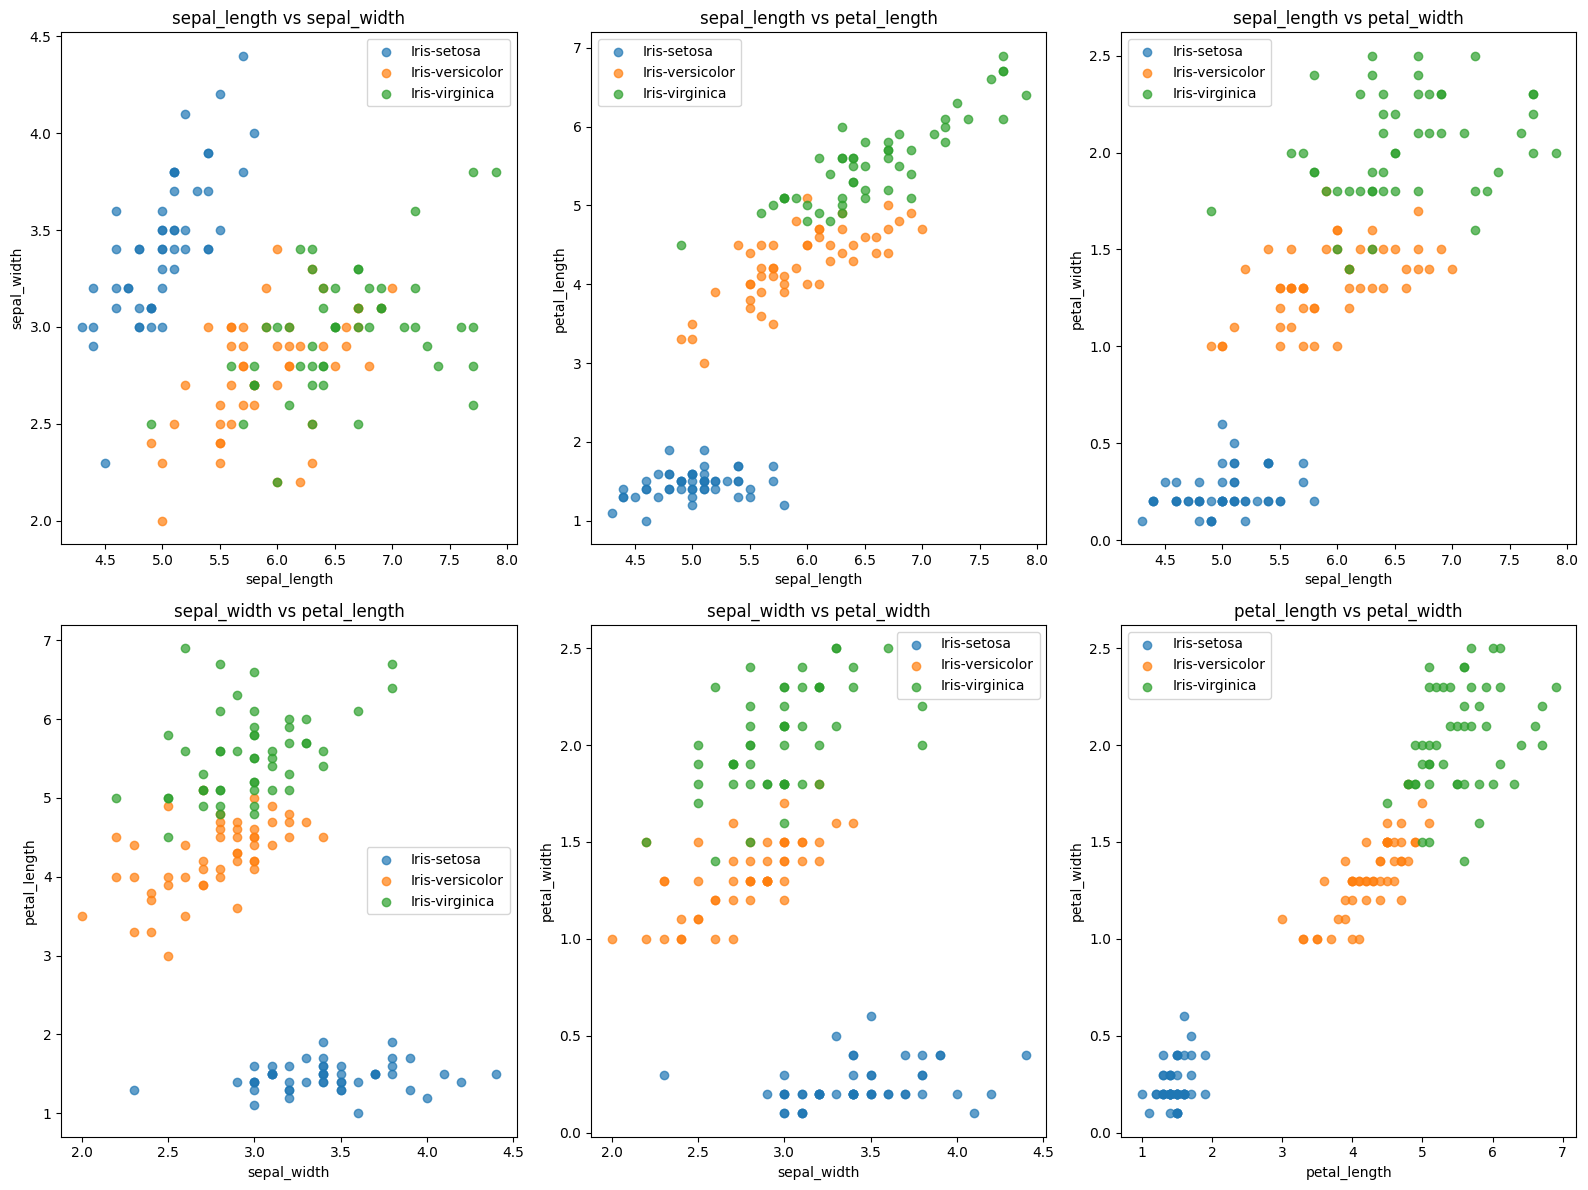

In [4]:
plot_feature_pairs(df_iris, label_column='species', figsize=(16, 12))

## Modified data and its distribution visualization 

##### Added some random Gaussian noise to the whole data, no more instances were added. This method makes the clusters more "fuzzy", making the boundary between two clusters less visible, disturbing the intra-cluster and inter-cluster distances.

In [5]:
df_noisy = df_iris.copy()
noise = np.random.normal(loc=0, scale=0.2, size=df_noisy.iloc[:, :4].shape)
df_noisy.iloc[:, :4] += noise


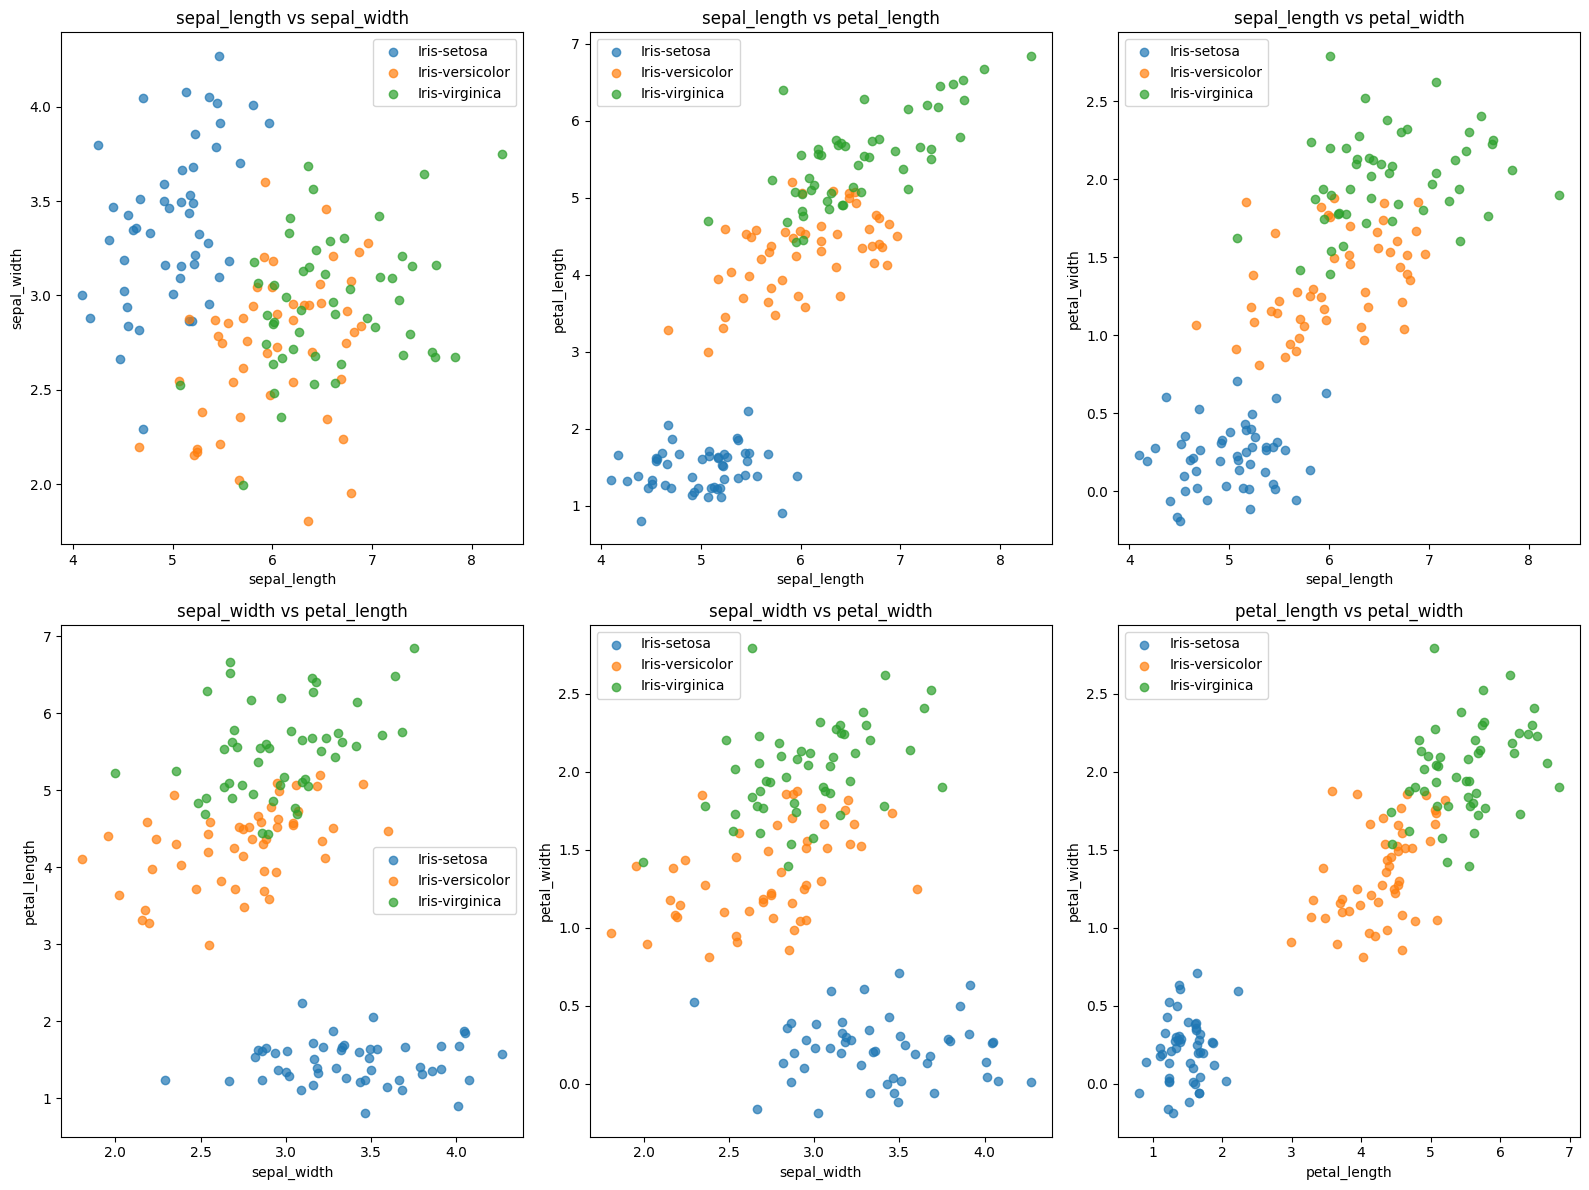

In [6]:
plot_feature_pairs(df_noisy, label_column='species', figsize=(16, 12))

## Added outliers based on inital guess for the data

##### Outliers are generated using fixed uniform ranges far outside the observed data. This method creates extreme values that are easy to detect, making them suitable for testing robust clustering algorithms. However, they may not reflect realistic noise patterns.

In [7]:
outliers = pd.DataFrame({
    'sepal_length': np.random.uniform(10, 15, 5),
    'sepal_width': np.random.uniform(5, 10, 5),
    'petal_length': np.random.uniform(10, 15, 5),
    'petal_width': np.random.uniform(5, 10, 5),
    'species': ['noise'] * 5
})
df_outlier = pd.concat([df_iris, outliers], ignore_index=True)

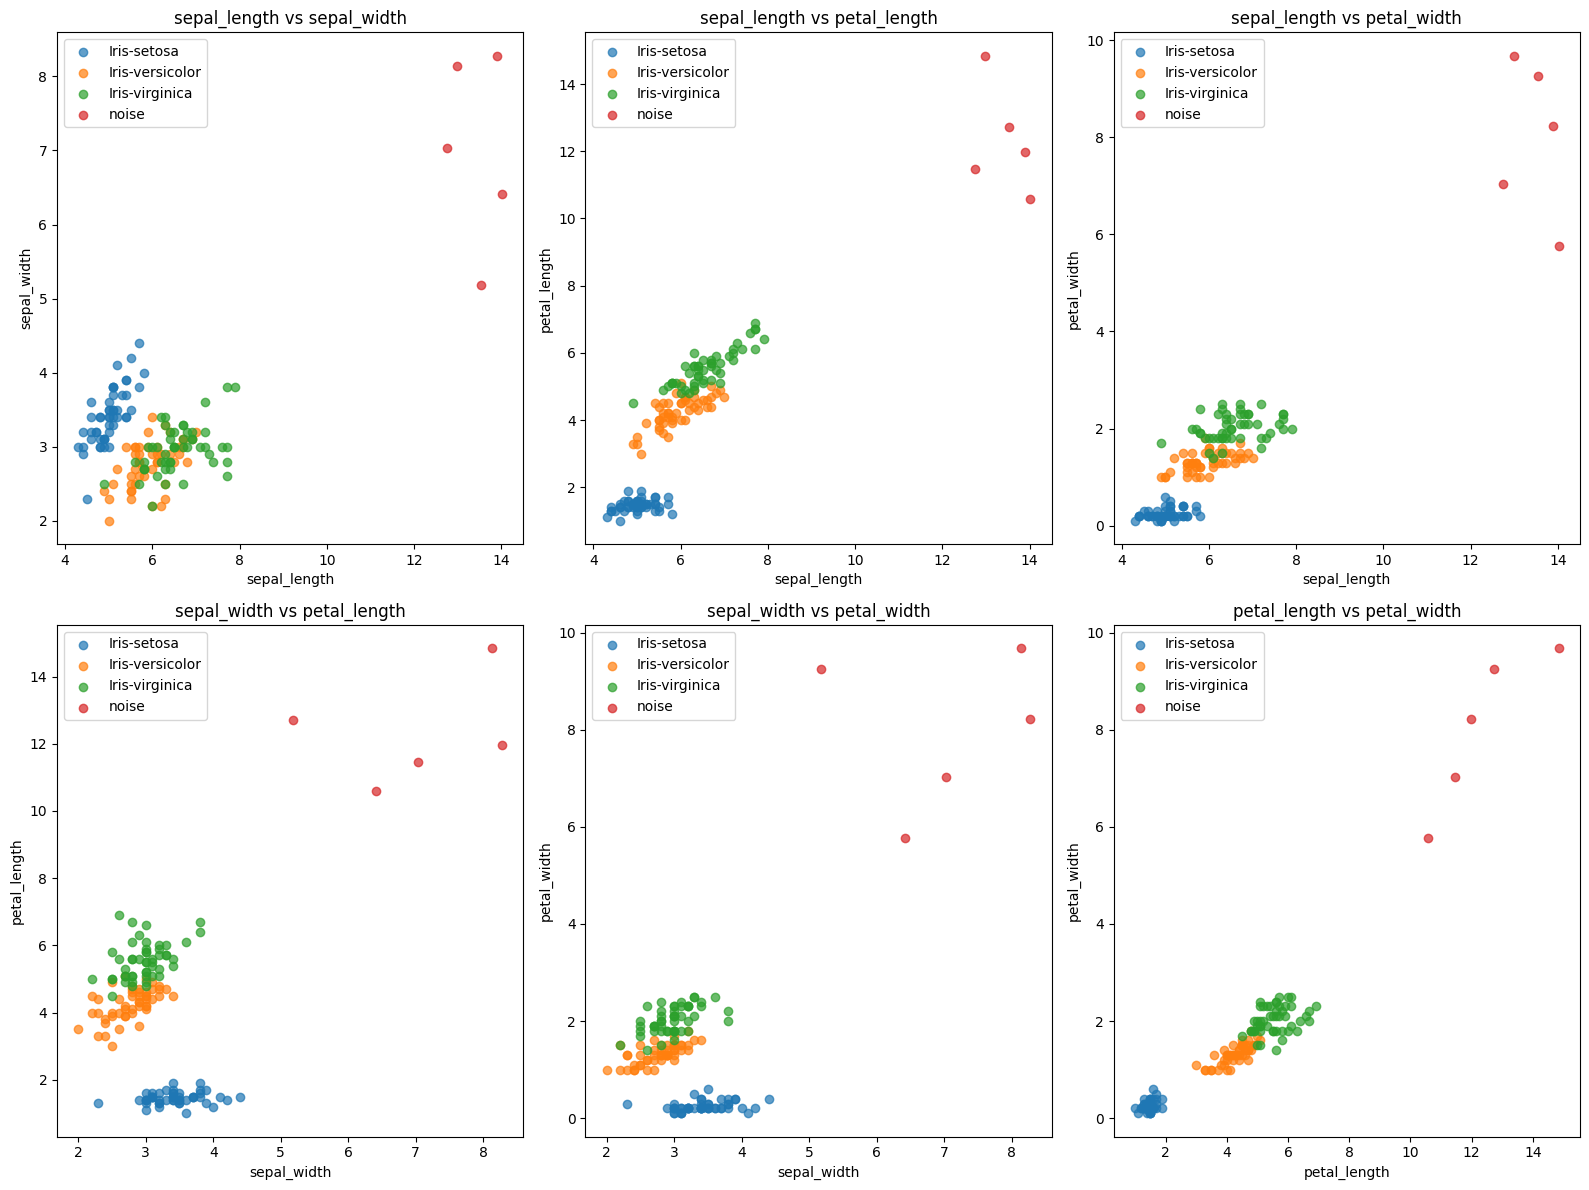

In [8]:
plot_feature_pairs(df_outlier, label_column='species', figsize=(16, 12))

## A more sophisticated random generated outlier injection

##### Outliers are generated using a multivariate normal distribution derived from the dataset's covariance structure and scaled slightly away from the mean. This method introduces realistic but misleading data points that respect the data's internal correlations. These outliers are hard to distinguish, making them excellent for testing clustering robustness under realistic noise.



In [11]:

def generate_subtle_outliers(df, label_column='species', n_outliers=5, exaggeration_factor=1.5, random_state=42):
    np.random.seed(random_state)
    features = df.select_dtypes(include='number').columns
    df_features = df[features]

    #mean and covariance
    mean_vec = df_features.mean().values
    cov_matrix = np.cov(df_features.T)

    #generate multivariate normal noise scaled from the mean
    outliers = np.random.multivariate_normal(
        mean=mean_vec,
        cov=cov_matrix,
        size=n_outliers
    )
    #scale away from the mean to make them more "unusual", but not extreme
    centered_outliers = outliers - mean_vec
    outliers_scaled = mean_vec + exaggeration_factor * centered_outliers

    outlier_df = pd.DataFrame(outliers_scaled, columns=features)
    outlier_df[label_column] = 'noise'

    return pd.concat([df, outlier_df], ignore_index=True)

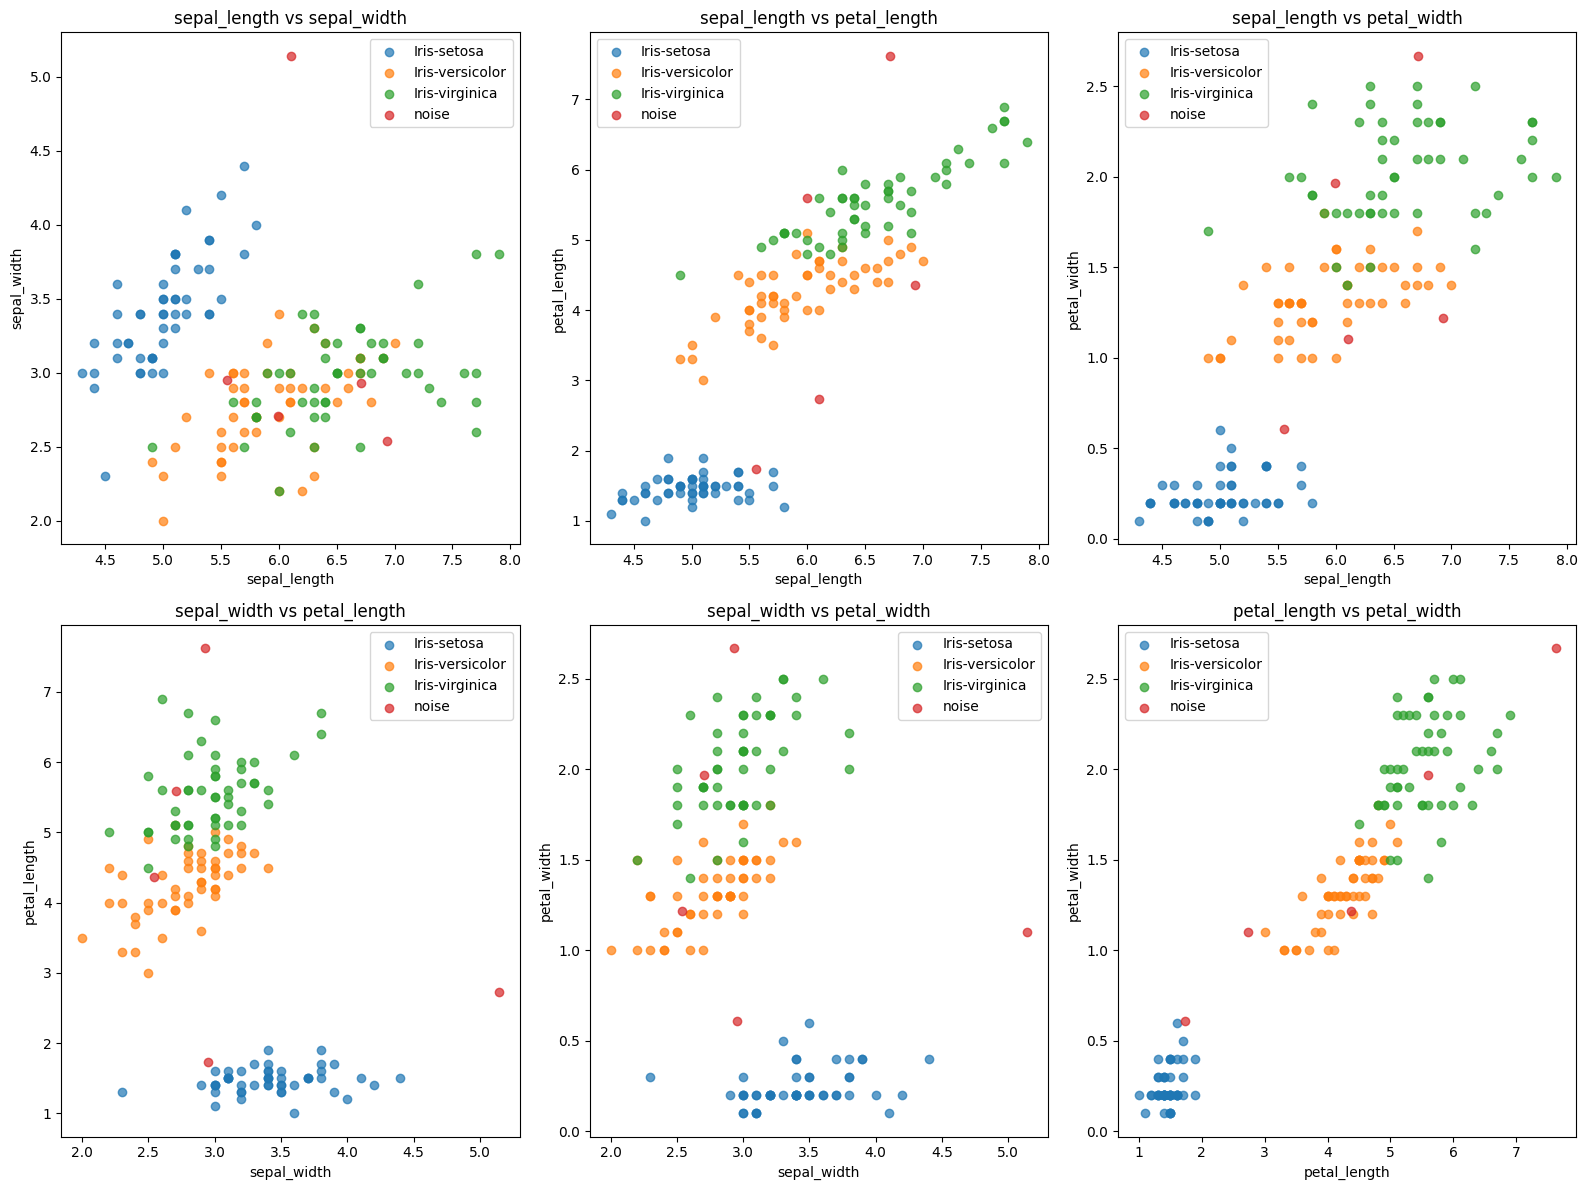

In [12]:
df_subtle_outliers = generate_subtle_outliers(df_iris, n_outliers=5, exaggeration_factor=2)
plot_feature_pairs(df_subtle_outliers, label_column='species', figsize=(16, 12))

## Shuffeled the data, 20% of the labels were shuffled

##### In this method, 20% of the dataset's class labels are randomly shuffled to introduce label noise. This simulates mislabeling errors or ambiguous instances that could misguide clustering evaluation or semi-supervised learning techniques. The underlying feature vectors remain unchanged, making this a subtle but impactful form of disturbance.

In [9]:
df_label_shuffled = df_iris.copy()

np.random.seed(42)
fraction_to_shuffle = 0.2
num_to_shuffle = int(fraction_to_shuffle * len(df_label_shuffled))

indices_to_shuffle = np.random.choice(df_label_shuffled.index, size=num_to_shuffle, replace=False)

shuffled_labels = np.random.permutation(df_label_shuffled.loc[indices_to_shuffle, 'species'].values)
df_label_shuffled.loc[indices_to_shuffle, 'species'] = shuffled_labels


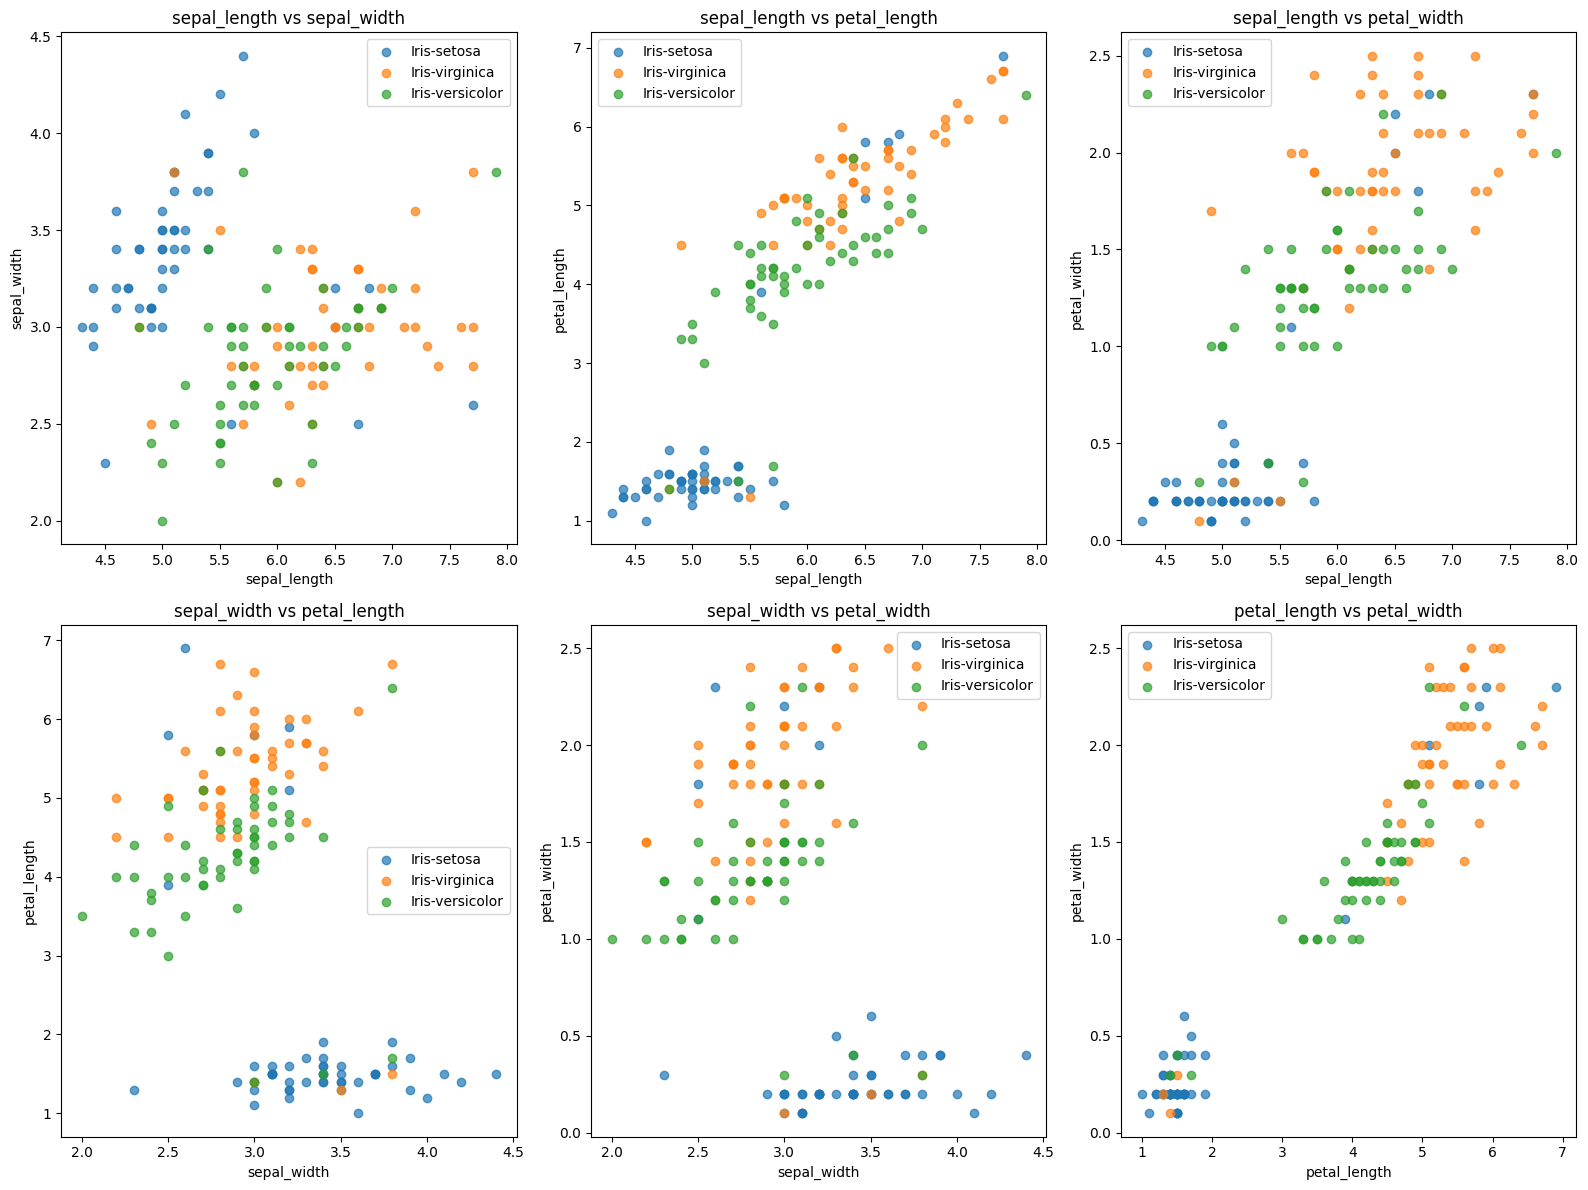

In [10]:
plot_feature_pairs(df_label_shuffled, label_column='species', figsize=(16, 12))